# Autoencoder for MNIST

The code is based on this tutorial: https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model
from keras import regularizers

# Convolutional Autoencoder
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
# Downloading and preprocessing the dataset.
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

# Normalization
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# 2D pic -> 784D vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


# Simple Autoencoder

In [3]:
def build_autoenc(encoding_dim=32, input_shape=(784,), sparsity=10e-8):

    # this is the size of our encoded representations
    encoding_dim = encoding_dim  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

    # this is our input placeholder
    input_img = Input(shape=input_shape)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', \
                    activity_regularizer=regularizers.l1(sparsity))(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_shape[0], activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (encoding_dim-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')  

    return autoencoder, encoder, decoder

In [16]:
autoencoder, encoder, decoder = build_autoenc(encoding_dim=36, input_shape=(784,), sparsity=10e-6)

In [5]:
#autoencoder.set_weights(nonreg_weights) # Used to set pretrained non-sparse weights into a regularized autoencoder.

In [17]:
history = autoencoder.fit(x_train, x_train, \
                          epochs=100, \
                          batch_size=256, \
                          shuffle=True, \
                          validation_data=(x_test, x_test), \
                          verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 5s - loss: 0.5292 - val_loss: 0.3326
Epoch 2/100
 - 4s - loss: 0.3228 - val_loss: 0.3150
Epoch 3/100
 - 4s - loss: 0.3110 - val_loss: 0.3072
Epoch 4/100
 - 4s - loss: 0.3048 - val_loss: 0.3023
Epoch 5/100
 - 4s - loss: 0.3006 - val_loss: 0.2987
Epoch 6/100
 - 4s - loss: 0.2974 - val_loss: 0.2960
Epoch 7/100
 - 4s - loss: 0.2949 - val_loss: 0.2937
Epoch 8/100
 - 4s - loss: 0.2928 - val_loss: 0.2918
Epoch 9/100
 - 4s - loss: 0.2910 - val_loss: 0.2900
Epoch 10/100
 - 4s - loss: 0.2894 - val_loss: 0.2885
Epoch 11/100
 - 4s - loss: 0.2880 - val_loss: 0.2872
Epoch 12/100
 - 4s - loss: 0.2866 - val_loss: 0.2859
Epoch 13/100
 - 4s - loss: 0.2854 - val_loss: 0.2847
Epoch 14/100
 - 4s - loss: 0.2843 - val_loss: 0.2837
Epoch 15/100
 - 4s - loss: 0.2832 - val_loss: 0.2826
Epoch 16/100
 - 4s - loss: 0.2822 - val_loss: 0.2816
Epoch 17/100
 - 4s - loss: 0.2813 - val_loss: 0.2807
Epoch 18/100
 - 4s - loss: 0.2804 - val_loss: 0.2798
Epoch

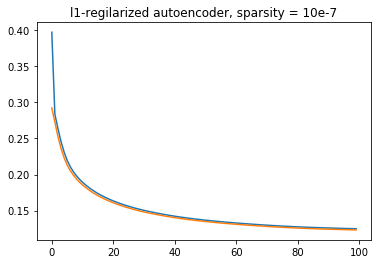

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('l1-regilarized autoencoder, sparsity = 10e-7')
plt.show()

In [8]:
# Used to track encoded/decoded means (see tutorial) for several training conditions.
encoded_means = []
decoded_means = []

In [9]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
encoded_means.append(encoded_imgs.mean())
decoded_imgs = decoder.predict(encoded_imgs)
decoded_means.append(decoded_imgs.mean())

In [10]:
#del encoded_means[-1]
#del decoded_means[-1]

In [10]:
print(encoded_means)
print(decoded_means)

[1.7421247]
[0.13265534]


In [11]:
def display_model(encoder, decoder, repr_shape=(8, 4)):
    """Display input, reconstruction and representations."""
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display representations
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(encoded_imgs[i].reshape(repr_shape))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

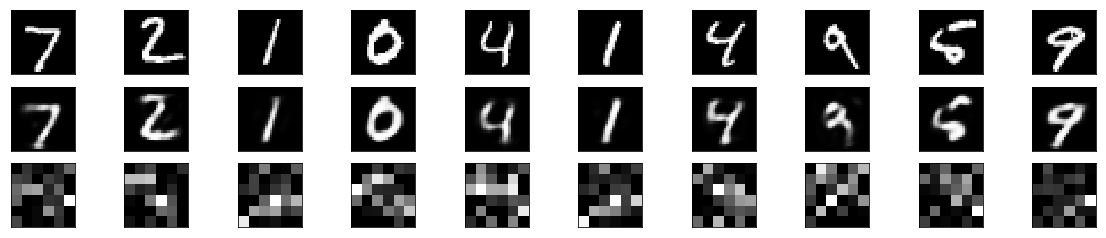

In [14]:
display_model(encoder, decoder, repr_shape=(6, 6))

In [15]:
autoencoder.save('data/mnist_tutorial/models_log/36_sparse_10e-7_autoencoder')
encoder.save('data/mnist_tutorial/models_log/36_sparse_10e-7_encoder')
decoder.save('data/mnist_tutorial/models_log/36_sparse_10e-7_decoder')

In [ ]:
# Used to set pretrained non-sparse weights into a regularized autoencoder.
#autoencoder = load_model('data/models_log/36_sparse_10e-8_autoencoder')
#encoder = load_model('data/models_log/36_sparse_10e-8_encoder')
#decoder = load_model('data/models_log/36_sparse_10e-8_decoder')

In [ ]:
#nonreg_weights = autoencoder.get_weights()

# Deep Autoencoder

In [9]:
def build_deep_autoenc(encoding_dim=32, input_shape=(784,), sparsity=0):
    input_img = Input(shape=(784,))
    encoded_1 = Dense(encoding_dim*4, activation='relu', \
                      activity_regularizer=regularizers.l1(sparsity))(input_img)
    encoded_2 = Dense(encoding_dim*2, activation='relu', \
                      activity_regularizer=regularizers.l1(sparsity))(encoded_1)
    encoded_3 = Dense(encoding_dim, activation='relu', \
                      activity_regularizer=regularizers.l1(sparsity))(encoded_2)

    # this model maps an input to its encoded representation
    deep_encoder = Model(input_img, encoded_3)

    decoded_1 = Dense(encoding_dim*2, activation='relu', \
                      activity_regularizer=regularizers.l1(sparsity))(encoded_3)
    decoded_2 = Dense(encoding_dim*4, activation='relu', \
                      activity_regularizer=regularizers.l1(sparsity))(decoded_1)
    decoded_3 = Dense(784, activation='sigmoid', \
                      activity_regularizer=regularizers.l1(sparsity))(decoded_2)

    deep_autoencoder = Model(input_img, decoded_3)

    deep_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return deep_autoencoder, deep_encoder

In [20]:
def build_deep_decoder(deep_autoencoder, encoding_dim=32, sparsity=0):
    # create a placeholder for an encoded (encoding_dim-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_1 = Dense(encoding_dim*2, activation='relu', \
                      activity_regularizer=regularizers.l1(sparsity))(encoded_input)
    decoder_2 = Dense(encoding_dim*4, activation='relu', \
                      activity_regularizer=regularizers.l1(sparsity))(decoder_1)
    decoder_3 = Dense(784, activation='sigmoid', \
                      activity_regularizer=regularizers.l1(sparsity))(decoder_2)
    # create the decoder model
    deep_decoder = Model(encoded_input, decoder_3)
    
    deep_decoder.set_weights(deep_autoencoder.get_weights()[-6:])
    
    return deep_decoder

In [11]:
deep_autoencoder, deep_encoder = build_deep_autoenc()

In [12]:
deep_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 784)               101136    
Total para

In [13]:
history_deep = deep_autoencoder.fit(x_train, x_train, \
                                    epochs=100, \
                                    batch_size=256, \
                                    shuffle=True, \
                                    validation_data=(x_test, x_test), \
                                    #callbacks=[TensorBoard(log_dir='/tmp/autoencoder/deep')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 6s 105us/step - loss: 0.3431 - val_loss: 0.2644
Epoch 2/100
60000/60000 [==============================] - 6s 105us/step - loss: 0.2597 - val_loss: 0.2558
Epoch 3/100
60000/60000 [==============================] - 6s 104us/step - loss: 0.2504 - val_loss: 0.2420
Epoch 4/100
60000/60000 [==============================] - 7s 108us/step - loss: 0.2329 - val_loss: 0.2235
Epoch 5/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.2165 - val_loss: 0.2094
Epoch 6/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.2074 - val_loss: 0.2041
Epoch 7/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.1991 - val_loss: 0.1921
Epoch 8/100
60000/60000 [==============================] - 6s 94us/step - loss: 0.1890 - val_loss: 0.1837
Epoch 9/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.1816 - val_loss:

Epoch 77/100
60000/60000 [==============================] - 7s 113us/step - loss: 0.1048 - val_loss: 0.1035
Epoch 78/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.1047 - val_loss: 0.1047
Epoch 79/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.1044 - val_loss: 0.1042
Epoch 80/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.1043 - val_loss: 0.1031
Epoch 81/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.1040 - val_loss: 0.1029
Epoch 82/100
60000/60000 [==============================] - 6s 105us/step - loss: 0.1038 - val_loss: 0.1017
Epoch 83/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.1036 - val_loss: 0.1020
Epoch 84/100
60000/60000 [==============================] - 8s 130us/step - loss: 0.1034 - val_loss: 0.1033
Epoch 85/100
60000/60000 [==============================] - 7s 123us/step - loss: 0.1031 - val_loss: 0.1020
Epoch 86/100
60000/60000 [==

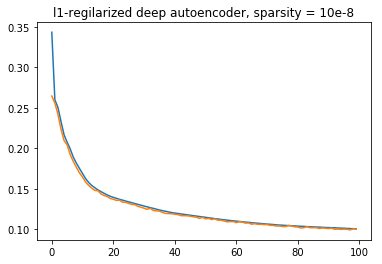

In [14]:
plt.plot(history_deep.history['loss'])
plt.plot(history_deep.history['val_loss'])
plt.title('l1-regilarized deep autoencoder, sparsity = 10e-8')
plt.show()

In [21]:
deep_decoder = build_deep_decoder(deep_autoencoder)

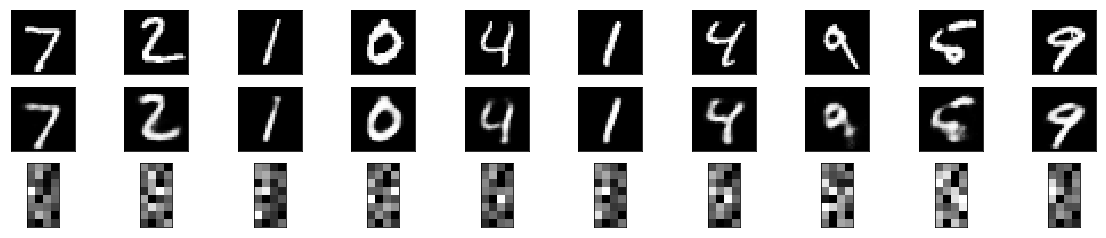

In [25]:
display_model(deep_encoder, deep_decoder, repr_shape=(8, 4))

In [27]:
deep_autoencoder.save('data/mnist_tutorial/models_log/32_deep_autoencoder')
deep_encoder.save('data/mnist_tutorial/models_log/32_deep_encoder')
deep_decoder.save('data/mnist_tutorial/models_log/32_deep_decoder')

# Convolutional Autoencoder

In [33]:
def build_conv_autoenc():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    # this model maps an input to its encoded representation
    conv_encoder = Model(input_img, encoded)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    conv_autoencoder = Model(input_img, decoded)

    conv_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return conv_autoencoder, conv_encoder

In [40]:
def build_conv_decoder(conv_autoencoder):
    # create a placeholder for an encoded (encoding_dim-dimensional) input
    encoded_input = Input(shape=(4, 4, 8))
    # retrieve the last layer of the autoencoder model
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    # create the decoder model
    conv_decoder = Model(encoded_input, decoded)
    
    conv_decoder.set_weights(conv_autoencoder.get_weights()[-6:])
    
    return conv_decoder

In [34]:
conv_autoencoder, conv_encoder = build_conv_autoenc()

In [36]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [37]:
history_conv = conv_autoencoder.fit(x_train, x_train,
                                    epochs=50,
                                    batch_size=128,
                                    shuffle=True,
                                    validation_data=(x_test, x_test),
                                    #callbacks=[TensorBoard(log_dir='/tmp/autoencoder/conv')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 108s 2ms/step - loss: 0.2443 - val_loss: 0.1850
Epoch 2/50
60000/60000 [==============================] - 100s 2ms/step - loss: 0.1694 - val_loss: 0.1558
Epoch 3/50
60000/60000 [==============================] - 96s 2ms/step - loss: 0.1547 - val_loss: 0.1487
Epoch 4/50
60000/60000 [==============================] - 94s 2ms/step - loss: 0.1452 - val_loss: 0.1365
Epoch 5/50
60000/60000 [==============================] - 88s 1ms/step - loss: 0.1383 - val_loss: 0.1373
Epoch 6/50
60000/60000 [==============================] - 87s 1ms/step - loss: 0.1335 - val_loss: 0.1294
Epoch 7/50
60000/60000 [==============================] - 101s 2ms/step - loss: 0.1297 - val_loss: 0.1269
Epoch 8/50
60000/60000 [==============================] - 97s 2ms/step - loss: 0.1264 - val_loss: 0.1240
Epoch 9/50
60000/60000 [==============================] - 99s 2ms/step - loss: 0.1235 - val_loss: 0.1212
Ep

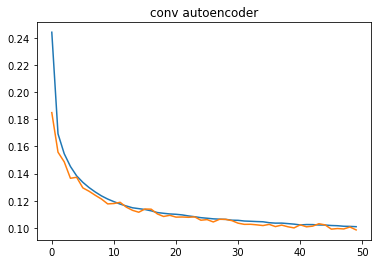

In [38]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('conv autoencoder')
plt.show()

In [47]:
encoded_imgs = conv_encoder.predict(x_test)
decoded_imgs = conv_autoencoder.predict(x_test)

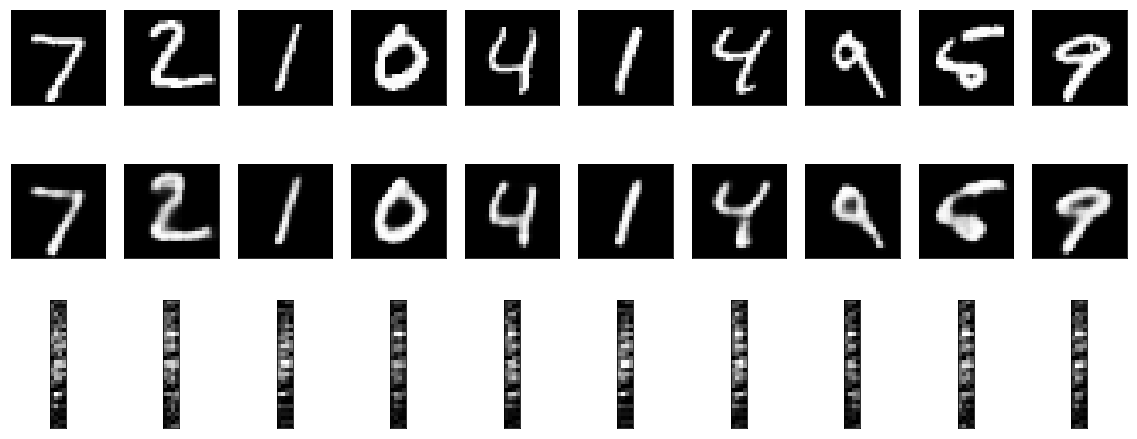

In [48]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising autoencoder

In [49]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

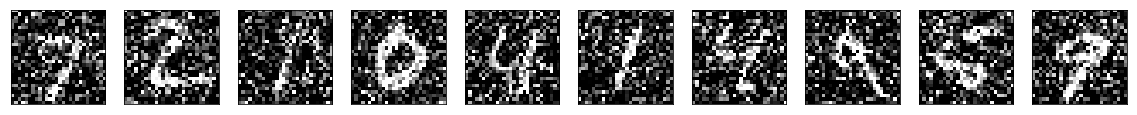

In [53]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [55]:
def build_deniois_autoenc():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    denois_encoder = Model(input_img, encoded)

    # at this point the representation is (7, 7, 32)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    denois_autoencoder = Model(input_img, decoded)
    denois_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return denois_autoencoder, denois_encoder

In [56]:
denois_autoencoder, denois_encoder = build_deniois_autoenc()

In [58]:
history_denois = denois_autoencoder.fit(x_train_noisy, x_train,
                                        epochs=100,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(x_test_noisy, x_test),
                                        callbacks=[TensorBoard(log_dir='/tmp/autoencoder/denois',
                                                               histogram_freq=0,
                                                               write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 205s 3ms/step - loss: 0.1988 - val_loss: 0.1376
Epoch 2/100
60000/60000 [==============================] - 203s 3ms/step - loss: 0.1261 - val_loss: 0.1171
Epoch 3/100
60000/60000 [==============================] - 186s 3ms/step - loss: 0.1168 - val_loss: 0.1129
Epoch 4/100
60000/60000 [==============================] - 192s 3ms/step - loss: 0.1122 - val_loss: 0.1080
Epoch 5/100
60000/60000 [==============================] - 192s 3ms/step - loss: 0.1091 - val_loss: 0.1072
Epoch 6/100
60000/60000 [==============================] - 193s 3ms/step - loss: 0.1073 - val_loss: 0.1063
Epoch 7/100
60000/60000 [==============================] - 191s 3ms/step - loss: 0.1057 - val_loss: 0.1040
Epoch 8/100
60000/60000 [==============================] - 190s 3ms/step - loss: 0.1045 - val_loss: 0.1029
Epoch 9/100
60000/60000 [==============================] - 205s 3ms/step - loss: 0.1038 - val_

KeyboardInterrupt: 

In [ ]:
plt.plot(history_denois.history['loss'])
plt.plot(history_denois.history['val_loss'])
plt.title('denois autoencoder')
plt.show()

In [ ]:
denois_autoencoder.predict